In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.modules.conv import Conv2d 
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm2d
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self):	
        super(Net, self).__init__()
        self.conv1=Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3,3), bias=False)
        self.bn1=BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.conv2=Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,1), bias=False)
        self.bn2=BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.conv3=Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,1),bias=False)
        self.bn3=BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.conv4=Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False)
        self.bn4=BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.conv5=Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False)
        self.bn5=BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.conv6=Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x=self.bn1(x)
        
        
        x=self.conv2(x)
        x = F.relu(x)
        x=F.max_pool2d(x, 2)
        x=self.bn2(x)
        
        
        x=self.conv3(x)
        x = F.relu(x)
        x=F.max_pool2d(x, 2)
        x=self.bn3(x)
        
        
        x=self.conv4(x)
        x = F.relu(x)
        x=F.max_pool2d(x, 2)
        x=self.bn4(x)
        
        
        x=self.conv5(x)
        x = F.relu(x)
        x=F.max_pool2d(x, 2)
        x=self.bn5(x)
        
        
        
        x=self.conv6(x)
        return x

In [3]:
model = Net() 
model=model.to(device)
# print(model)

In [4]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness1_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
# data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
# label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [6]:
for epoch in range(1):
    for i,data in enumerate(train_loader):
        inputs, label=data
#         print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())
        print(len(data))
        print(data[0].shape)
        print(inputs.shape)
        print(label.shape)
        print(type(data[0][0][0][0]))
        break
        
        

2
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 8, 8])
<class 'torch.Tensor'>


In [7]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
        if epoch%20==0:
            torch.save(model, 'models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [8]:
print(model)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [9]:
loss_func=nn.MSELoss()
num_epochs=300
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(trained_model, 'models/'+'best_model.pt')
 


Epoch: 1/300


/home/chase/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: Loss: 0.5888, MAE: 0.6090, 
Validation: Loss: 0.6068, MAE: 0.5277, 
Time: 0.6125s
Best Error for validation : 0.5277 at epoch 001
Epoch: 2/300
Training: Loss: 0.1963, MAE: 0.3527, 
Validation: Loss: 2.9835, MAE: 1.5660, 
Time: 0.5104s
Best Error for validation : 0.5277 at epoch 001
Epoch: 3/300
Training: Loss: 0.1461, MAE: 0.3098, 
Validation: Loss: 5.0134, MAE: 2.0610, 
Time: 0.5072s
Best Error for validation : 0.5277 at epoch 001
Epoch: 4/300
Training: Loss: 0.1165, MAE: 0.2761, 
Validation: Loss: 2.9434, MAE: 1.5672, 
Time: 0.5039s
Best Error for validation : 0.5277 at epoch 001
Epoch: 5/300
Training: Loss: 0.0927, MAE: 0.2471, 
Validation: Loss: 1.5213, MAE: 1.1173, 
Time: 0.5082s
Best Error for validation : 0.5277 at epoch 001
Epoch: 6/300
Training: Loss: 0.0796, MAE: 0.2306, 
Validation: Loss: 0.8317, MAE: 0.8162, 
Time: 0.5059s
Best Error for validation : 0.5277 at epoch 001
Epoch: 7/300
Training: Loss: 0.0706, MAE: 0.2165, 
Validation: Loss: 0.3687, MAE: 0.5153, 
Time

Training: Loss: 0.0045, MAE: 0.0523, 
Validation: Loss: 0.0397, MAE: 0.1560, 
Time: 0.5108s
Best Error for validation : 0.1518 at epoch 048
Epoch: 56/300
Training: Loss: 0.0041, MAE: 0.0503, 
Validation: Loss: 0.0383, MAE: 0.1528, 
Time: 0.5077s
Best Error for validation : 0.1518 at epoch 048
Epoch: 57/300
Training: Loss: 0.0035, MAE: 0.0466, 
Validation: Loss: 0.0395, MAE: 0.1534, 
Time: 0.4976s
Best Error for validation : 0.1518 at epoch 048
Epoch: 58/300
Training: Loss: 0.0035, MAE: 0.0466, 
Validation: Loss: 0.0413, MAE: 0.1592, 
Time: 0.5059s
Best Error for validation : 0.1518 at epoch 048
Epoch: 59/300
Training: Loss: 0.0033, MAE: 0.0444, 
Validation: Loss: 0.0397, MAE: 0.1530, 
Time: 0.5082s
Best Error for validation : 0.1518 at epoch 048
Epoch: 60/300
Training: Loss: 0.0027, MAE: 0.0410, 
Validation: Loss: 0.0389, MAE: 0.1543, 
Time: 0.5058s
Best Error for validation : 0.1518 at epoch 048
Epoch: 61/300
Training: Loss: 0.0027, MAE: 0.0409, 
Validation: Loss: 0.0399, MAE: 0.1565,

Training: Loss: 0.0008, MAE: 0.0226, 
Validation: Loss: 0.0387, MAE: 0.1514, 
Time: 0.5075s
Best Error for validation : 0.1508 at epoch 103
Epoch: 110/300
Training: Loss: 0.0010, MAE: 0.0244, 
Validation: Loss: 0.0390, MAE: 0.1533, 
Time: 0.5054s
Best Error for validation : 0.1508 at epoch 103
Epoch: 111/300
Training: Loss: 0.0012, MAE: 0.0280, 
Validation: Loss: 0.0388, MAE: 0.1524, 
Time: 0.5062s
Best Error for validation : 0.1508 at epoch 103
Epoch: 112/300
Training: Loss: 0.0011, MAE: 0.0262, 
Validation: Loss: 0.0397, MAE: 0.1544, 
Time: 0.5077s
Best Error for validation : 0.1508 at epoch 103
Epoch: 113/300
Training: Loss: 0.0015, MAE: 0.0305, 
Validation: Loss: 0.0406, MAE: 0.1559, 
Time: 0.5076s
Best Error for validation : 0.1508 at epoch 103
Epoch: 114/300
Training: Loss: 0.0016, MAE: 0.0318, 
Validation: Loss: 0.0403, MAE: 0.1578, 
Time: 0.5036s
Best Error for validation : 0.1508 at epoch 103
Epoch: 115/300
Training: Loss: 0.0020, MAE: 0.0350, 
Validation: Loss: 0.0398, MAE: 0

Training: Loss: 0.0006, MAE: 0.0193, 
Validation: Loss: 0.0378, MAE: 0.1500, 
Time: 0.5062s
Best Error for validation : 0.1490 at epoch 134
Epoch: 163/300
Training: Loss: 0.0007, MAE: 0.0209, 
Validation: Loss: 0.0373, MAE: 0.1491, 
Time: 0.5080s
Best Error for validation : 0.1490 at epoch 134
Epoch: 164/300
Training: Loss: 0.0005, MAE: 0.0171, 
Validation: Loss: 0.0375, MAE: 0.1494, 
Time: 0.5080s
Best Error for validation : 0.1490 at epoch 134
Epoch: 165/300
Training: Loss: 0.0005, MAE: 0.0176, 
Validation: Loss: 0.0376, MAE: 0.1488, 
Time: 0.5050s
Best Error for validation : 0.1488 at epoch 165
Epoch: 166/300
Training: Loss: 0.0006, MAE: 0.0191, 
Validation: Loss: 0.0377, MAE: 0.1495, 
Time: 0.5078s
Best Error for validation : 0.1488 at epoch 165
Epoch: 167/300
Training: Loss: 0.0006, MAE: 0.0196, 
Validation: Loss: 0.0380, MAE: 0.1505, 
Time: 0.5043s
Best Error for validation : 0.1488 at epoch 165
Epoch: 168/300
Training: Loss: 0.0007, MAE: 0.0210, 
Validation: Loss: 0.0373, MAE: 0

Training: Loss: 0.0005, MAE: 0.0176, 
Validation: Loss: 0.0368, MAE: 0.1474, 
Time: 0.5037s
Best Error for validation : 0.1470 at epoch 213
Epoch: 216/300
Training: Loss: 0.0005, MAE: 0.0170, 
Validation: Loss: 0.0371, MAE: 0.1475, 
Time: 0.5054s
Best Error for validation : 0.1470 at epoch 213
Epoch: 217/300
Training: Loss: 0.0004, MAE: 0.0164, 
Validation: Loss: 0.0372, MAE: 0.1499, 
Time: 0.5061s
Best Error for validation : 0.1470 at epoch 213
Epoch: 218/300
Training: Loss: 0.0006, MAE: 0.0192, 
Validation: Loss: 0.0372, MAE: 0.1481, 
Time: 0.5081s
Best Error for validation : 0.1470 at epoch 213
Epoch: 219/300
Training: Loss: 0.0007, MAE: 0.0208, 
Validation: Loss: 0.0366, MAE: 0.1474, 
Time: 0.5074s
Best Error for validation : 0.1470 at epoch 213
Epoch: 220/300
Training: Loss: 0.0005, MAE: 0.0182, 
Validation: Loss: 0.0374, MAE: 0.1492, 
Time: 0.5076s
Best Error for validation : 0.1470 at epoch 213
Epoch: 221/300
Training: Loss: 0.0006, MAE: 0.0188, 
Validation: Loss: 0.0379, MAE: 0

Training: Loss: 0.0005, MAE: 0.0168, 
Validation: Loss: 0.0367, MAE: 0.1468, 
Time: 0.5034s
Best Error for validation : 0.1460 at epoch 242
Epoch: 269/300
Training: Loss: 0.0005, MAE: 0.0180, 
Validation: Loss: 0.0369, MAE: 0.1486, 
Time: 0.5061s
Best Error for validation : 0.1460 at epoch 242
Epoch: 270/300
Training: Loss: 0.0006, MAE: 0.0188, 
Validation: Loss: 0.0367, MAE: 0.1460, 
Time: 0.5059s
Best Error for validation : 0.1460 at epoch 242
Epoch: 271/300
Training: Loss: 0.0004, MAE: 0.0161, 
Validation: Loss: 0.0367, MAE: 0.1471, 
Time: 0.5102s
Best Error for validation : 0.1460 at epoch 242
Epoch: 272/300
Training: Loss: 0.0004, MAE: 0.0152, 
Validation: Loss: 0.0366, MAE: 0.1473, 
Time: 0.5053s
Best Error for validation : 0.1460 at epoch 242
Epoch: 273/300
Training: Loss: 0.0004, MAE: 0.0153, 
Validation: Loss: 0.0367, MAE: 0.1472, 
Time: 0.5080s
Best Error for validation : 0.1460 at epoch 242
Epoch: 274/300
Training: Loss: 0.0003, MAE: 0.0146, 
Validation: Loss: 0.0370, MAE: 0

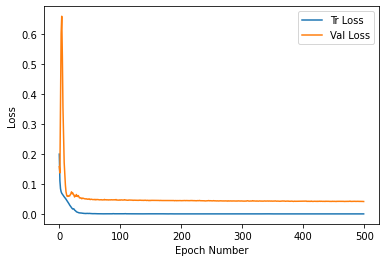

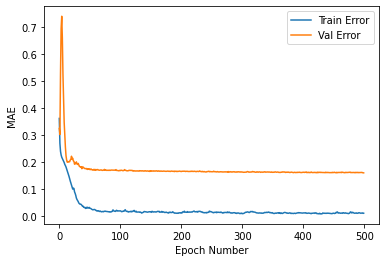

In [56]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('error_curve.png')
plt.show()

In [57]:
data.shape

AttributeError: 'list' object has no attribute 'shape'

In [24]:
result=model(test_sample)
result

tensor([[[[0.5631, 0.1613, 0.2831, 0.1240, 0.8366, 0.5690, 0.7362, 0.4886],
          [0.0742, 0.9606, 0.4491, 0.4479, 0.6530, 0.5563, 0.1661, 0.4700],
          [0.5010, 0.6659, 0.5144, 0.3786, 0.7997, 0.0676, 0.6715, 0.7638],
          [0.0919, 0.0576, 0.5811, 0.3686, 0.8451, 0.2421, 0.0748, 0.8471],
          [0.6665, 0.0609, 0.0922, 0.0808, 0.6040, 0.8294, 0.3668, 0.0388],
          [0.8125, 0.7152, 0.5228, 0.8383, 0.3344, 0.7030, 0.4074, 0.5135],
          [0.6818, 0.2215, 0.6831, 0.5449, 0.5332, 0.6988, 0.5042, 0.5323],
          [0.2559, 0.6910, 0.2404, 0.8101, 0.6730, 0.6057, 0.1841, 0.7367]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [26]:
result_sample=torch.unsqueeze(test_y[0],0).to(device)

In [27]:
result_sample

tensor([[[[0.6125, 0.1979, 0.2406, 0.1793, 0.8570, 0.5676, 0.6852, 0.4797],
          [0.0252, 0.9620, 0.4662, 0.4342, 0.5943, 0.5465, 0.0063, 0.4676],
          [0.3534, 0.7350, 0.4841, 0.4371, 0.8043, 0.1661, 0.6479, 0.6845],
          [0.0677, 0.0090, 0.5210, 0.4059, 0.7147, 0.2345, 0.0966, 0.7759],
          [0.5437, 0.2324, 0.0677, 0.1109, 0.7154, 0.7373, 0.4614, 0.0300],
          [0.8700, 0.7075, 0.4881, 0.9723, 0.4534, 0.6483, 0.3494, 0.5438],
          [0.6012, 0.1513, 0.7136, 0.3365, 0.5521, 0.9445, 0.4872, 0.5929],
          [0.2073, 0.6932, 0.2435, 0.9906, 0.8046, 0.4374, 0.2315, 0.7283]]]],
       device='cuda:0')

In [28]:
result_sample-result

tensor([[[[ 0.0495,  0.0366, -0.0426,  0.0553,  0.0203, -0.0014, -0.0511,
           -0.0089],
          [-0.0490,  0.0014,  0.0172, -0.0137, -0.0586, -0.0098, -0.1598,
           -0.0024],
          [-0.1476,  0.0691, -0.0304,  0.0585,  0.0046,  0.0985, -0.0235,
           -0.0793],
          [-0.0242, -0.0486, -0.0601,  0.0373, -0.1304, -0.0076,  0.0218,
           -0.0712],
          [-0.1228,  0.1716, -0.0245,  0.0301,  0.1114, -0.0922,  0.0946,
           -0.0089],
          [ 0.0575, -0.0077, -0.0346,  0.1340,  0.1190, -0.0547, -0.0580,
            0.0302],
          [-0.0806, -0.0702,  0.0305, -0.2084,  0.0189,  0.2457, -0.0170,
            0.0606],
          [-0.0486,  0.0022,  0.0031,  0.1805,  0.1316, -0.1683,  0.0474,
           -0.0084]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
history[-1]

array([9.16668803e-05, 1.10731925e-02, 7.42801220e-03, 7.17941964e-02])